# Trabalho 4 - Aplicação de DQN em Pong Atari

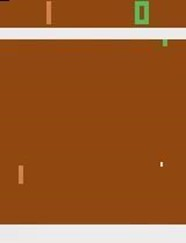




## 1) Objetivos

*   Desenvolver e treinar agente de Aprendizado por Reforço em jogo Pong com capacidade de derrotar inteligência artificial padrão do jogo.
*   Implementação de algoritmo DQN e de técnicas de convergência como *Experience Replay*, *Target Network* e *$\epsilon$-greedy Exploration*.
*   Implementação de loop principal de aquisição de experiência e treino do agente, armazenamento de *score* e visualização de resultados.

## 2) Introdução

  Jogos constituem ambientes propícios para implementação e validação de algoritmos de Aprendizado por Reforço devido à facilidade de formulação de suas estruturas em MDPs: As regras do jogo constituem a dinâmica de transição de estados do MDP enquanto a pontuação do jogo pode ser usada como recompensa.

  Pong é um jogo de Atari no qual o objetivo é marcar 21 pontos contra um adversário, para marcar um ponto o jogador deve rebater um projétil de forma a dificultar a defesa por parte do adversário, ultrapassando a extremidade da tela defendida pelo mesmo. A velocidade e trajetória do projétil dependem da forma como ele é rebatido e faz parte da dinâmica do jogo.

  O agente a ser treinado tem acesso às mesmas observações disponíveis a um jogador humano: imagens do estado atual do jogo capturadas pelo emulador.

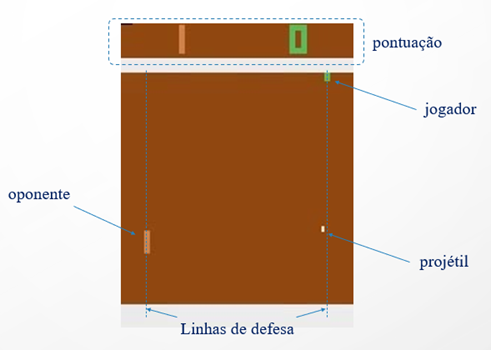


## 3) OpenAI gym Atari Environment

  OpenAI gym (https://github.com/openai/gym) é uma biblioteca desenvolvida para benchmarking de algoritmos de Aprendizado por Reforço em diversos ambientes de forma padronizada, de modo que é possível comparar diretamente seu desempenho com outros algoritmos. O gym Atari é uma API implementada sobre o ALE (Arcade Learning Environment) que simula diversos jogos do console Atari a partir do emulador Stella.

  Um gym environment é a classe que implementa a dinâmica do ambiente, recebendo as ações tomadas pelo agente e retornando o estado seguinte e a recompensa obtida, assim como uma variável que indica o término do episódio. O environment do jogo Pong é carregado da seguinte forma:

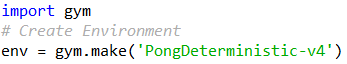

Os seguintes atributos do objeto env especificam as dimensões dos espaços de estados e ações respectivamente:

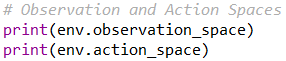

Para visualizar as ações possíveis pode-se utilizar a seguinte função:

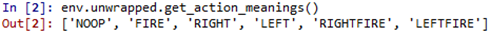

Como o jogo Pong só possui três ações (ficar parado, se mover para cima, se mover para baixo), as seis ações acima são mapeadas da seguinte forma:

*   Ficar parado: 'NOOP'(0), 'FIRE'(1)
*   Se mover para cima: 'RIGHT'(2), 'RIGHTFIRE'(4)
*   Se mover para baixo: 'LEFT'(3), 'LEFTFIRE'(5)

A função de dinâmica do ambiente é denominada env.step (https://github.com/openai/gym/blob/master/gym/envs/atari/atari_env.py):

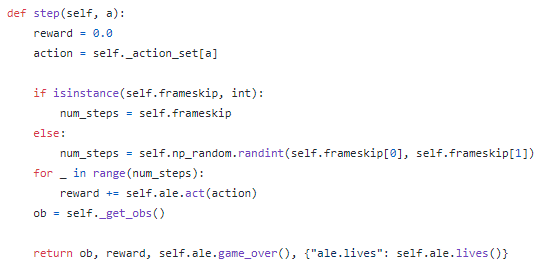

onde o parâmetro recebido é a ação $a∈\{0,1,2,3,4,5\}$ e as variáveis retonadas são: a imagem associada ao estado seguinte do jogo (no caso do ambiente ‘PongDeterministic-v4’), a recompensa (um valor escalar que indica se a ação tomada levou o jogador a marcar um ponto) e uma Booleana que indica o término de um episódio:

*   $r=0$: Nenhum jogador marcou um gol.
*   $r=1$: Jogador marcou um gol.
*   $r=-1$: Adversário macou um gol.



## 4) Tarefas

a) (1 ponto) Determinar as dimensões dos espaços de observações e ações.

b) (2 pontos) Simular um agente aleatório por 10 episódios $\{S_0,A_0,R_1,...,S_{T-1},A_{T-1},R_{T}\}_{k=1}^{50}\sim\pi_{rand}$ e plotar os scores de cada episódio, onde o placar de um episódio é dado por $Score_k=\sum_{t=1}^{T}R_t^{(k)} \in [-21,21]$. Quantos gols foram marcados pelo agente aleatório no total ao longo dos 10 episódios?

c) (3 pontos) Implementar funções get_action, add_experience e sample_batch da classe DQAgent.

d) (4 pontos) Implementar loop principal de treino.

## 5) Código

Nesta seção será desenvolvido o código do trabalho. Algumas classes e funções encontram-se prontas enquanto as funções especificadas nas tarefas devem ser implementadas de modo a apresentarem as entradas e saídas especificadas. Células adicionais de código podem ser acrescentadas para testar cada função individualmente.

### Google Drive

Mount de drive e configuração de working directory para permitir salvar resultados.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Ir para o path dentro de seu drive onde deseja salvar os resultados com o comando (por exemplo):

%cd /content/drive/My Drive/AprendizadoPorReforco/Aula5/T1

In [ ]:
%cd /content/drive/Shareddrives/Aulas\ Maua\ RL/Trabalhos/T1_Jogo_Pong
%ls

### Imports

Importar bibliotecas necessárias

In [1]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from PIL import Image
from random import random, randrange, randint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Lambda
from tensorflow.keras import backend as K

### Variáveis Globais e Parâmetros de Execução

Definição de variáveis globais e hiperparâmetros do algoritmo, como número de episódios de treino, tamanho de *Experience Replay*, fator de desconto $\gamma$ e taxa de decaimento de $\epsilon$.

In [2]:
ENV_NAME = 'PongDeterministic-v4'      # Environment Name
RENDER_VIDEO = False                   # Whether to render video during training
IMG_SIZE = (105, 80)                   # Image Size after preprocessing (height, width)
NET_INPUT_SHAPE = (105, 80, 3)         # Network Input Shape
MAX_EPISODES = 201                     # Maximum Number of Episodes to be simulated
#MAX_TIMESTEPS_PER_EPISODE = np.inf     # Maximum number of timsteps in a single episode
MAX_TIMESTEPS_PER_EPISODE = np.iinfo(np.int32).max
EXPERIENCE_REPLAY_SIZE = 1.5e5         # Maximum Size of Experience Replay Memory
EXPERIENCE_START_SIZE = 50e3           # Minimum number of random transitions to store before training
MINIBATCH_SIZE = 32                    # Size of minibatch sampled during training
TARGET_NETWORK_UPDATE_FREQ = 1e3       # Rate at which DQN_target is synchronized with DQN
LEARNING_RATE = 0.00025                # Learning rate used during training
DISCOUNT_FACTOR = 0.99                 # MDP discount factor gamma
DROPOUT_PROB = 0.1                     # Dropout rate for the DQN
INITIAL_EPSILON = 1                    # Initial value of epsilon for epsilon-greedy policy
EPSILON_DECREASE_RATE = 5e-6           # Epsilon decrease rate
MIN_EPSILON = 0.1                      # Minimum epsilon value to guarantee minimum exploration later

### Criação de Environment

In [3]:
# https://github.com/openai/gym/issues/1726
# https://stackoverflow.com/questions/63080326/could-not-find-module-atari-py-ale-interface-ale-c-dll-or-one-of-its-dependenc
# Create Environment
env = gym.make('PongDeterministic-v4')

### Tarefa a)
Determinar as dimensões dos espaços de observações e ações.

In [4]:
# Escreva um código abaixo para obter e imprimir as dimensões dos espaços de observações e ações:

# Observation Space
print(env.observation_space)

# Action Space
print(env.action_space)

# Action Meanings
print('Action Meanings:')
env.unwrapped.get_action_meanings()

Box(0, 255, (210, 160, 3), uint8)
Discrete(6)
Action Meanings:


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

### *Wrappers*

Vamos acrescentar funcionalidades ao Environment por meio de *wrappers* para processamento de imagens do jogo e codificação de estados a partir de últimas *frames*.

In [5]:
# ImagePreprocessor
# Converte imagens do jogo para grayscale e efetua redimensionamento.
class ImagePreprocessor(gym.Wrapper):
    
    def __init__(self, env, height, width, grayscale=True):
        
        super().__init__(env)
        
        self.height = int(height)
        self.width = int(width)
        self.grayscale = bool(grayscale)
        
        # check original shape / dtype
        shape = self.env.observation_space.shape
        dtype = self.env.observation_space.dtype
        assert len(shape) == 3, "bad shape: {}".format(shape)
        assert shape[2] == 3, "bad shape: {}".format(shape)
        assert dtype == 'uint8', "bad dtype: {}".format(dtype)
        
        # update observation space
        if self.grayscale:
            shape = (self.height, self.width)
        else:
            shape = (self.height, self.width, shape[2])
        self.observation_space = gym.spaces.Box(
            shape=shape, low=0, high=255, dtype='uint8')


    def _preprocess_frame(self, s):
        img = Image.fromarray(s)
        if self.grayscale:
            img = img.convert('L')
        img = img.resize((self.width, self.height))
        return np.array(img)


    def reset(self):
        self._s_orig = self.env.reset()
        s = self._preprocess_frame(self._s_orig)   # shape: [h, w]
        return s


    def step(self, a):
        self._s_next_orig, r, done, info = self.env.step(a)
        s_next = self._preprocess_frame(self._s_next_orig)
        return s_next, r, done, info

In [6]:
# FrameStacker
# Armazena últimas observações do jogo como estado para permitir abstração de movimento por parte do agente.
class FrameStacker(gym.Wrapper):
    
    def __init__(self, env, num_frames=4):
        
        super().__init__(env)

        self.num_frames = int(num_frames)
        
        s = self.env.observation_space.sample()
        if s.ndim == 2:
            self._perm = (1, 2, 0)
        elif s.ndim == 3:
            self._perm = (1, 2, 3, 0)
        else:
            print("expected ndim equal to 2 or 3, got shape: {}".format(s.shape))
        
        # update observation space
        shape = s.shape + (self.num_frames,)
        self.observation_space = gym.spaces.Box(
            shape=shape, low=0, high=255, dtype='uint8')


    def reset(self):
        frame_shape = tuple(self.env.observation_space.shape)  # [h, w, c?]
        shape = (self.num_frames,) + frame_shape               # [f, h, w, c?]
        self._frames = np.zeros(shape, self.observation_space.dtype)
        self._s_orig = self.env.reset()             # shape: [h, w, c?]
        s = np.expand_dims(self._s_orig, axis=0)    # shape: [1, h, w, c?]
        self._frames[...] = s                       # broadcast along axis=0
        s = np.transpose(self._frames, self._perm)  # to shape: [h, w, c?, f]
        return s


    def step(self, a):
        self._s_next_orig, r, done, info = self.env.step(a)
        self._frames = np.roll(self._frames, -1, axis=0)
        self._frames[-1] = self._s_next_orig
        s_next = np.transpose(self._frames, self._perm)  # shape: [h, w, c?, f]
        return s_next, r, done, info

Vamos agora aplicar os wrappers no objeto env, de modo que chamadas futuras das funções reset() e step() retornarão os estados já processados.

In [7]:
env = ImagePreprocessor(env, height=105, width=80, grayscale=True) # s shape: [h, w]
env = FrameStacker(env, num_frames=3) # s shape: [h, w, f]

### Função Auxiliar: Geração de GIFs para tarefa b)

In [8]:
def generate_gif(frames_list, duration=50):
    """
    Store a gif from the episode frames.
    Parameters
    ----------
    frames_list: List of "env.render(mode='rgb_array')" frames to save.
    duration : float, optional
        Time between frames in the animated gif, in milliseconds.
    """
    
    print('Generating GIF')

    filepath = 'gifs/tarefa_b.gif'

    # Process frames
    for i in range(0,len(frames_list)):
        preprocessed_frame = frames_list[i]
        frame = Image.fromarray(preprocessed_frame)
        frame = frame.convert('P', palette=Image.ADAPTIVE)
        frames_list[i] = frame

    # generate gif
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    frames_list[0].save(
                    fp=filepath, format='GIF', append_images=frames_list[1:], save_all=True,
                    duration=duration, loop=0)

### Tarefa b)

Simulação e análise de desempenho de agente aleatório: Antes de implementar o treino de um agente DQN, vamos simular um agente aleatório no ambiente e observar as recompensas obtidas.

Implemente a função **simulate_random_agent(env, N_episodes)** que recebe o ambiente e o número de episódios a serem simulados, salva um GIF do primeiro episódio, simula todos e retorna o número total de gols marcados pelo agente aleatório.

No final de cada episódio, imprima na tela o score obtido, onde $Score=\sum_{t=1}^{T}R_t$ é a soma total das recompensas obtidas no episódio e é um número entre -21 e 21.

Cada episódio é definido como um jogo completo de Pong até que um dos jogadores faça 21 gols (done==True).

Sugestão: Uma ação aleatória pode ser amostrada pela função **env.action_space.sample()**. Cada frame do GIF pode ser obtida com a função **env.render(mode='rgb_array')** e armazenada em uma lista para ser passada à função **generate_gif(frames_list)**.

In [9]:
def simulate_random_agent(env, N_episodes):
    '''
    env: OpenAI gym environment.
    N_episodes: Number of episodes to simulate random agent.
    '''

    # Implemente aqui a função
    N_gols = 0
    frames_list = []
    
    for episode in range(N_episodes):
        
        s = env.reset()
        done = False
        r_ep = 0
        if episode == 0:
            frames_list.append( env.render(mode='rgb_array') )
        
        while not done:
            
            a = env.action_space.sample()
            s_next, r, done, info = env.step(a)
            r_ep += r
            if episode == 0:
                frames_list.append( env.render(mode='rgb_array') )
        
        N_gols += r_ep
        print('Número de gols no episodio {0} = {1}'.format(episode+1, int(r_ep)))
    
    generate_gif(frames_list)
    
    return N_gols

In [10]:
N_gols = simulate_random_agent(env, N_episodes=10)
print("Número total de gols feitos por agente aleatório = " + str(N_gols))

Número de gols no episodio 1 = -20
Número de gols no episodio 2 = -21
Número de gols no episodio 3 = -20
Número de gols no episodio 4 = -19
Número de gols no episodio 5 = -20
Número de gols no episodio 6 = -20
Número de gols no episodio 7 = -20
Número de gols no episodio 8 = -20
Número de gols no episodio 9 = -20
Número de gols no episodio 10 = -19
Generating GIF
Número total de gols feitos por agente aleatório = -199.0


### Classe DQNetwork

Classe com implementação de rede neural convolucional para representação da Função Valor dos pares Estao-Ação $Q(s,a)$.

In [11]:
def diff_transform_matrix(num_frames):
    # Obtenção de matriz de transformação diferencial M, que mantém a shape dos estados,
    # mas transforma frames em imagens que representam [posição, velocidade, aceleração]
    # para melhorar convergência e acelerar o treino.
    assert isinstance(num_frames, int) and num_frames >= 1
    s = np.diag(np.power(-1, np.arange(num_frames)))  # alternating sign
    m = s.dot(scipy.linalg.pascal(num_frames, kind='upper'))[::-1, ::-1]
    M = K.constant(m, dtype='float32')
    return M

In [12]:
class DQNetwork:
    def __init__(self,
                 name,
                 actions,
                 input_shape,
                 learning_rate=0.00025,
                 discount_factor=0.99,
                 minibatch_size=32,
                 dropout_prob=0.1):
        
        # Parameters
        self.name = name
        self.actions = actions  # Size of the network output
        self.discount_factor = discount_factor  # Discount factor of the MDP
        self.minibatch_size = minibatch_size  # Size of the training batches
        self.learning_rate = learning_rate  # Learning rate
        self.dropout_prob = dropout_prob  # Probability of dropout
        
        def diff_transform(S):
            S = K.cast(S, 'float32') / 255
            M = diff_transform_matrix(num_frames=3)
            return K.dot(S, M)
        
        
        S = keras.Input(name='S', shape=input_shape, dtype='uint8')
        # Lambda Layer
        lambda_layer = Lambda(diff_transform)(S)
        # Conv2D Layers
        conv_layer_1 = Conv2D(filters=16, kernel_size=8, strides=4, activation='relu')(lambda_layer)
        conv_layer_2 = Conv2D(filters=32, kernel_size=4, strides=2, activation='relu')(conv_layer_1)
        # Flatten
        flatten_layer = Flatten()(conv_layer_2)
        # Dense Layer
        X = Dense(units=256, activation='relu')(flatten_layer)
        # Output Layer
        Q = keras.layers.Dense(units=actions,
                               activation='linear',
                               kernel_initializer='zeros',
                               name='Q')(X)
        self.model = keras.Model(inputs=S, outputs=Q)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='huber_loss')
    
    
    def train(self, batch, DQN_target):
        """
        Generates inputs and targets from the given batch, trains the model on
        them.
        
        batch: iterable of dictionaries with keys 'state', 'action',
        'next_state', 'reward', 'final'
        DQN_target: a target model to generate targets
        """
        
        States = [datapoint['state'] for datapoint in batch]
        Next_States = [datapoint['next_state'] for datapoint in batch]
        Q_train = []
        
        # Apply DQN and DQN_target to every datapoint simultaneously to reduce computation time
        Current_States_Q_Values = self.model(tf.concat(States,axis=0)).numpy()   # Current States
        Next_States_Q_Values = DQN_target(tf.concat(Next_States,axis=0)).numpy() # Next States
        Next_States_Max_Q_Values = np.max(Next_States_Q_Values,axis=1)           # Max Q Values
        
        # Build Q_train targets
        for i in range(0,len(batch)):
            datapoint = batch[i]
            # The error must be 0 on all actions except the one taken
            y = list(Current_States_Q_Values[i,:])
            if datapoint['final']:
                y[datapoint['action']] = datapoint['reward']
            else:
                y[datapoint['action']] = datapoint['reward'] + \
                                         self.discount_factor * Next_States_Max_Q_Values[i]
            Q_train.append(y)
            

        # Prepare inputs and targets
        S_train = np.asarray(States).squeeze()
        Q_train = np.asarray(Q_train).squeeze()
        
        
        # Train the model for one epoch
        self.model.train_on_batch(S_train,
                                  Q_train)
        
    
    
    def predict(self, state):
        """
        Feeds state to the model, returns predicted Q-values.
        state: a numpy.array with same shape as the network's input
        
        :return: numpy.array with predicted Q-values
        """
        return self.model.predict(state, batch_size=1)
    
    
    def save(self):
        """
        Saves the model weights to disk.
        :param filename: file to which save the weights (must end with ".h5")
        :param append: suffix to append after "model" in the default filename
            if no filename is given
        """
        self.model.save(self.name)

### Classe DQAgent

Classe que representa o agente e implementa métodos para obtenção de ações a partir de rede DQN e acréscimo e amostragem de experiências ao *Experience Replay*.

### Tarefa c)

Implementar funções **get_action**, **add_experience** e **sample_batch** da classe DQAgent.

In [13]:
class DQAgent:
    def __init__(self,
                 actions,
                 network_input_shape=(4, 110, 84),
                 replay_memory_size=1024,
                 minibatch_size=32,
                 learning_rate=0.00025,
                 discount_factor=0.99,
                 dropout_prob=0.1,
                 epsilon=1,
                 epsilon_decrease_rate=9e-7,
                 min_epsilon=0.1):
        
        # Parameters
        self.actions = actions  # Size of the discrete action space
        self.network_input_shape = network_input_shape  # Shape of the DQN input
        self.replay_memory_size = replay_memory_size  # Size of replay memory
        self.minibatch_size = minibatch_size  # Size of a DQN minibatch
        self.learning_rate = learning_rate  # Learning rate for the DQN
        self.discount_factor = discount_factor  # Discount factor of the MDP
        self.dropout_prob = dropout_prob  # Dropout probability of the DQN
        self.epsilon = epsilon  # Probability of taking a random action
        self.epsilon_decrease_rate = epsilon_decrease_rate  # See update_epsilon
        self.min_epsilon = min_epsilon  # Minimum value for epsilon
        
        # Replay memory
        self.experience_replay = []
        self.training_count = 0
        
        # Instantiate the deep Q-networks
        # Main DQN
        self.DQN = DQNetwork(
            'DQN',
            self.actions,
            self.network_input_shape,
            learning_rate=self.learning_rate,
            discount_factor=self.discount_factor,
            minibatch_size=self.minibatch_size,
            dropout_prob=self.dropout_prob)
        
        # Target DQN used to generate targets
        self.DQN_target = keras.models.clone_model(self.DQN.model)
        self.DQN_target.trainable = False  # exclude from trainable weights
        
    
    
    def get_action(self, state, training=True):
        """
        Polls DQN for Q-values. Returns argmax(Q) with probability 1-epsilon
        during training, 0 during testing.
        
        state: a state that can be passed as input to DQN
        training: whether to use the current epsilon or return greedy action
        random_action: whether to sample a random action regardless of parameters
        
        :return: the index of (action associated to) the highest Q-value 
        """
        # Se training==True:
        #                   retornar np.argmax(q_values) com probabilidade (1-self.epsilon) --- Greedy Action
        #                   retornar randint(0, self.actions - 1) com probabilidade self.epsilon --- Random Action
        # Se training==False:
        #                   retornar np.argmax(q_values) --- Greedy Action

        # Escreva seu código aqui
        action = None
        
        if training == True:
            if random() > self.epsilon: # greedy
                action = self.get_max_q( state )
            else: # aleatorio
                action = randint( 0, self.actions - 1 )
        else:
            action = self.get_max_q( state )
        
        return action
    
    def get_max_q(self, state):
        """
        Returns the action corresponding to maximum Q value predicted on the given state.
        :param state: a state that can be passed as input to DQN
        :return: an action index corresponding to the maximum Q-value in the 
            given state
        """
        q_values = self.DQN.predict(state)
        idxs = np.argwhere(q_values == np.max(q_values)).ravel()
        return np.random.choice(idxs)
    
    
    def get_random_state(self):
        """
        Samples a random state from the replay memory.
        :return: the sampled state
        """
        return self.experience_replay[randrange(0, len(self.experience_replay))]['state']
    
    
    def add_experience(self, state, action, reward, next_state, final):
        """
        Add a SARS' tuple to the experience replay.
        :param state: current state
        :param action: action index
        :param reward: reward associated to the transition
        :param next_state: next state
        :param final: whether the state is absorbing
        """
        # Verificar memória do Experience Replay e remover transição mais antiga se
        # len(self.experience_replay) >= self.replay_memory_size utilizando função:
        # self.experience_replay.pop(0)

        # Armazenar transição (state, action, reward, next_state, final) em self.experience_replay
        # no formato de um dicionário {'state': state,
        #                              'action': action,
        #                              'reward': reward,
        #                              'next_state': next_state,
        #                              'final': final}

        # Escreva seu código aqui
        if len(self.experience_replay) >= self.replay_memory_size:
            self.experience_replay.pop(0)

        self.experience_replay.append( {'state': state,
                                      'action': action,
                                      'reward': reward,
                                      'next_state': next_state,
                                      'final': final} )
    
    def sample_batch(self):
        """
        Samples self.minibatch_size random transitions from the replay memory
        and returns them as a batch.
        :return: a batch of SARS' tuples
        """
        # Amostrar batch de self.minibatch_size transições
        # aleatórias de self.experience_replay

        batch = []
        
        # Implemente aqui a amostragem de transições aleatórias em batch
        #for i in range(self.minibatch_size):
        #    rand = randint( 0, len(self.experience_replay) - 1 )
        #    batch.append( self.experience_replay[ rand ] )
        
        rand = randint( 0, len(self.experience_replay) - 1 - self.minibatch_size )
        for i in range( rand, rand + self.minibatch_size ):
            batch.append( self.experience_replay[ i ] )
            
        return np.asarray(batch)
    
    
    def train(self):
        """
        Trains the DQN on a minibatch of transitions.
        """
        self.training_count += 1
#        print ('Training session #%d - epsilon: %f' % \
#              (self.training_count, self.epsilon))
        batch = self.sample_batch()
        
        self.DQN.train(batch, self.DQN_target)  # Train the DQN
    
    
    def update_epsilon(self):
        """
        Decreases the probability of picking a random action, to improve
        exploitation.
        """
        if self.epsilon - self.epsilon_decrease_rate > self.min_epsilon:
            self.epsilon -= self.epsilon_decrease_rate
        else:
            self.epsilon = self.min_epsilon
    
    
    def sync_target_network(self):
        """
        Updates the target DQN with the current weights of the main DQN.
        """
        #print('Synchronizing Target Network')
        self.DQN_target.set_weights(self.DQN.model.get_weights())
    
    
    def save_networks(self):
        """
        Saves DQN and DQN_target.
        """
        self.DQN.save()
        self.DQN_target.save()

Vamos criar um agente DQA a partir da classe DQAgent:

In [14]:
# Create Agent
DQA = DQAgent(env.action_space.n,
              network_input_shape=NET_INPUT_SHAPE,
              replay_memory_size=EXPERIENCE_REPLAY_SIZE,
              minibatch_size=MINIBATCH_SIZE,
              learning_rate=LEARNING_RATE,
              discount_factor=DISCOUNT_FACTOR,
              dropout_prob=DROPOUT_PROB,
              epsilon=INITIAL_EPSILON,
              epsilon_decrease_rate=EPSILON_DECREASE_RATE,
              min_epsilon=MIN_EPSILON)

### Função Auxiliar: Geração de GIFs

Esta função pode se chamada periodicamente no loop principal de treino para geração de GIFs para monitoração do progresso do agente. Cada animação é gerada a partir da simulação de um episódio completo (jogo até que um jogador marque 21 gols), por meio de um comportamento *greedy* do agente.

In [15]:
def generate_gif_from_agent(env, agent, episode_index, resize_to=None, duration=50):
    """
    Store a gif from the episode frames.
    Parameters
    ----------
    env : gym environment
        The environment to record from.
    agent : DQAgent object
        The agent with policy that is used to take actions.
    episode_index : int
        Episode Index (used only to name the gif)
    resize_to : tuple of ints, optional
        The size of the output frames, ``(width, height)``. Notice the
        ordering: first **width**, then **height**. This is the convention PIL
        uses.
    duration : float, optional
        Time between frames in the animated gif, in milliseconds.
    """
    
    print('Generating GIF')

    filepath = 'gifs/ep{:06d}.gif'.format(episode_index)

    # collect frames
    frames = []
    s = env.reset()
    for t in range(env.spec.max_episode_steps or 10000):
        a = agent.get_action(np.asarray([s]), training=False)
        s_next, r, done, info = env.step(a)

        # store frame
        frame = env.render(mode='rgb_array')
        frame = Image.fromarray(frame)
        frame = frame.convert('P', palette=Image.ADAPTIVE)
        if resize_to is not None:
            if not (isinstance(resize_to, tuple) and len(resize_to) == 2):
                raise TypeError("expected a tuple of size 2, resize_to=(w, h)")
            frame = frame.resize(resize_to)

        frames.append(frame)

        if done:
            break

        s = s_next

    # store last frame
    frame = env.render(mode='rgb_array')
    frame = Image.fromarray(frame)
    frame = frame.convert('P', palette=Image.ADAPTIVE)
    if resize_to is not None:
        frame = frame.resize(resize_to)
    frames.append(frame)

    # generate gif
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    frames[0].save(
        fp=filepath, format='GIF', append_images=frames[1:], save_all=True,
        duration=duration, loop=0)

### Função Auxiliar: Plot Scores

Função que recebe lista de scores ao longo de episódios de treino e plota gráfico de curva de aprendizado.

In [16]:
def plot_scores(scores_list):
    plt.style.use('fivethirtyeight')

    fig = plt.figure()
    ax = fig.gca()
    ax.plot(scores_list)
    fig.suptitle('Training Scores', fontsize=16)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Score = $ \sum R_t $')


### Tarefa d) Loop Principal de Treino

Vamos implementar o loop de treino do agente. Lembre-se de criar um loop externo para os episódios e um loop interno para os timesteps de cada episódio, no qual é verificado o final do mesmo a partir da variável "done" retornada pela função **env.step()**. No começo de cada episódio deve-se chamar a função **env.reset()**, que reinicia o ambiente e retona o estado inicial.

O código deve:

*   Inicializar variável **scores_list = [ ]**
*   Implementar loop de **MAX_EPISODES** episódios.
    * Inicializar ambiente com **s = env.reset()**
    * Implementar loop de **MAX_TIMESTEPS_PER_EPISODE** timesteps.
        * Selecionar ação a ser tomada a partir de estado s e agente DQA por meio da função **DQA.get_action(np.asarray([s]))**
        * Executar dinâmica do ambiente por meio de função **s_next, r, done, info = env.step(a)**
        * Armazenar a transição (s,a,r,s_next,done) por meio da função **DQA.add_experience(np.asarray([s]), action, reward, np.asarray([s_next]), done)**
        * Se len(DQA.experience_replay) >= EXPERIENCE_START_SIZE, treinar agente com função **DQA.train()** e atualizar epsilon com função **DQA.update_epsilon()**.
        * Se DQA.training_count % TARGET_NETWORK_UPDATE_FREQ == 0, sincronizar target network com função **DQA.sync_target_network()**
        * **s <- s_next**
        * Se done==True, armazenar score em **scores_list** e interromper loop do episódio com **break**
    * A cada 50 episódios, executar função **generate_gif_from_agent(env=env, agent=DQA, episode_index=episode, resize_to=(320, 420))** para monitorar treinamento.

Resultado esperado para 200 episódios:

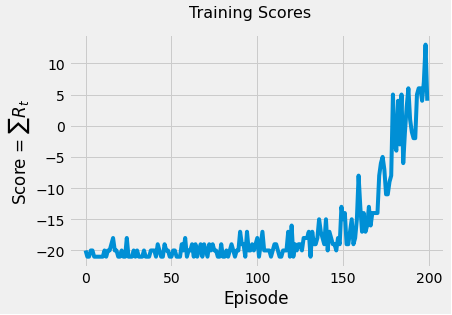

In [17]:
from datetime import datetime
import time

In [18]:
# Treinamento de Agente DQN em ambiente Pong
scores_list = []

for episode in range( MAX_EPISODES ):
    
    if episode % int(MAX_EPISODES / MAX_EPISODES) == 0:
        print('--------------------------------------')
        print('{0} -> Episodio  = {1}'.format( datetime.now(), episode ))
    s = env.reset()
    score = 0
    done = False
    timesteps = 0
    start_time = time.time()

    for timesteps in range( MAX_TIMESTEPS_PER_EPISODE ):
    #while not done:
        
        action = DQA.get_action( np.asarray([s]) )
        s_next, reward, done, info = env.step( action )
        DQA.add_experience( np.asarray([s]), action, reward, np.asarray([s_next]), done )
        
        if len(DQA.experience_replay) >= EXPERIENCE_START_SIZE:
            DQA.train()
            DQA.update_epsilon()
        
        if DQA.training_count % TARGET_NETWORK_UPDATE_FREQ == 0:
            DQA.sync_target_network()
        
        s = s_next
        score += reward
        timesteps += 1
        
        if done:
            scores_list.append(score)
            end_time = time.time() - start_time
            print('{0} -> Tempo     = {1:.2f}'.format( datetime.now(), end_time ))
            print('{0} -> Score     = {1}'.format( datetime.now(), score ))
            print('{0} -> Timesteps = {1}'.format( datetime.now(), timesteps ))
            print('--------------------------------------\n')
            break
    
    if episode % 50 == 0:
        generate_gif_from_agent(env=env, agent=DQA, episode_index=episode, resize_to=(320, 420))
        pass

--------------------------------------
2021-04-21 19:22:04.424733 -> Episodio  = 0
2021-04-21 19:22:10.337084 -> Tempo     = 5.90
2021-04-21 19:22:10.337208 -> Score     = -21.0
2021-04-21 19:22:10.338100 -> Timesteps = 764
--------------------------------------

Generating GIF
--------------------------------------
2021-04-21 19:23:05.952654 -> Episodio  = 1
2021-04-21 19:23:12.602435 -> Tempo     = 6.64
2021-04-21 19:23:12.602564 -> Score     = -21.0
2021-04-21 19:23:12.602598 -> Timesteps = 862
--------------------------------------

--------------------------------------
2021-04-21 19:23:12.602682 -> Episodio  = 2
2021-04-21 19:23:19.543746 -> Tempo     = 6.93
2021-04-21 19:23:19.543872 -> Score     = -21.0
2021-04-21 19:23:19.543908 -> Timesteps = 902
--------------------------------------

--------------------------------------
2021-04-21 19:23:19.543995 -> Episodio  = 3
2021-04-21 19:23:26.928283 -> Tempo     = 7.37
2021-04-21 19:23:26.928431 -> Score     = -19.0
2021-04-21 19:2

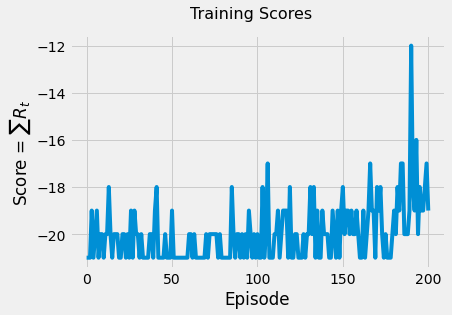

In [19]:
plot_scores(scores_list)